# Researching the data
First have a look at the data and see what we have to work with.

In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import FunctionTransformer


train_ds = pd.read_csv('data/train.csv')

# Data description
Define all columns and the type of feature they are, numerical or categorical or ordinal.
* Danceability: Numerical feature - a measure from 0 to 10 describing how suitable a track is for dancing.
* Track: string feature - name of the song, as visible on the Spotify platform.
* Artist: string feature - name of the artist.
* Composer: string feature - name of the composer.
* Album: string feature - the album in which the song is contained on Spotify.
* Channel: string feature - name of the channel that has published the video.
* Title: string feature - title of the video clip on YouTube.
* Album_type: Categorical feature - indicates if the song is released on Spotify as a single or contained in an album.
* Key: Categorical feature - the key the track is in, mapped to pitches using standard Pitch Class notation.
* Licensed: Categorical feature - indicates whether the video represents licensed content.
* official_video: Categorical feature - boolean value that indicates if the video found is the official video of the song.
* Energy: Numerical feature - a measure from 0.0 to 1.0 representing the perceptual measure of intensity and activity.
* Loudness: Numerical feature - the overall loudness of a track in decibels (dB).
* Speechiness: Numerical feature - detects the presence of spoken words in a track.
* Acousticness: Numerical feature - a confidence measure from 0.0 to 1.0 of whether the track is acoustic.
* Instrumentalness: Numerical feature - predicts whether a track contains no vocals.
* Liveness: Numerical feature - detects the presence of an audience in the recording.
* Valence: Numerical feature - a measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track.
* Tempo: Numerical feature - the overall estimated tempo of a track in beats per minute (BPM).
* Duration_ms: Numerical feature - the duration of the track in milliseconds.
* Stream: Numerical feature - number of streams of the song on Spotify.
* Views: Numerical feature - number of views.
* Likes: Numerical feature - number of likes.
* Comments: Numerical feature - number of comments.
* Description: string feature - description of the video on YouTube.

In [158]:
label_feature = 'Danceability'
numerical_features = ['Energy', 'Loudness', 'Speechiness', 'Acousticness',
                      'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Duration_ms', 'Stream',
                      'Views', 'Likes', 'Comments']

categorical_features = ['Album_type', 'Key', 'Licensed', 'official_video']

string_features = [
    'Track', 'Artist', 'Composer', 'Album', 'Title', 'Channel', 'Description'
]

columns = [label_feature] + numerical_features + categorical_features + string_features

# Nan values percentage
for each columns we find the percentage of Nan values

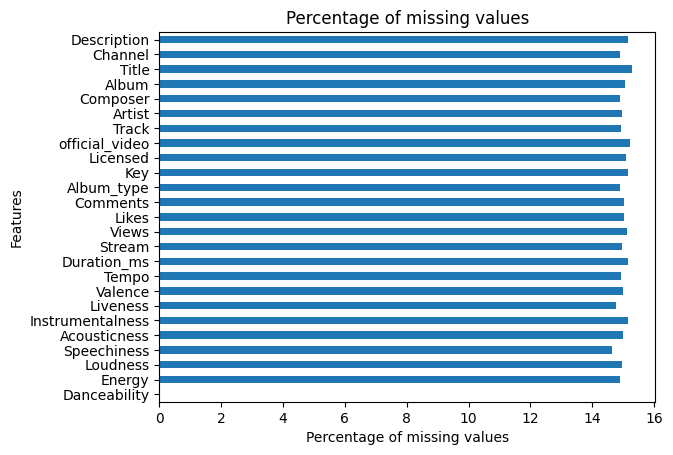

In [159]:
(train_ds[columns].isna().sum() / len(train_ds) * 100).plot.barh()
# plt.gcf().set_size_inches(5, 6)  # Set figure size
plt.title("Percentage of missing values")
plt.xlabel("Percentage of missing values")
plt.ylabel("Features")
plt.show()


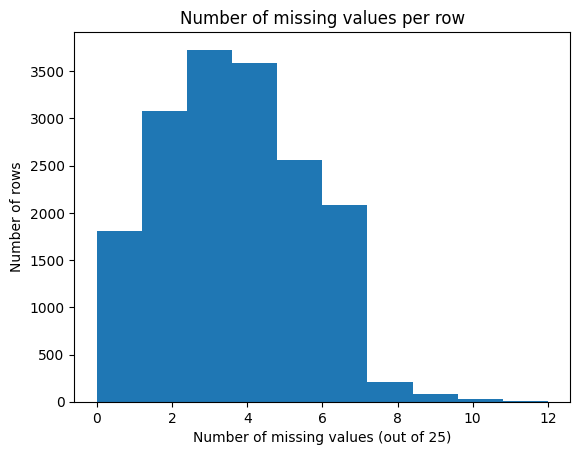

In [160]:
# for each row, how many features are missing value
train_ds[columns].isna().sum(axis=1).plot.hist()
plt.title("Number of missing values per row")
plt.xlabel("Number of missing values (out of 25)")
plt.ylabel("Number of rows")
plt.show()

solution of missing values
1. add binary variable for each feature to indicate rather the value is missing
2. train a model to predict missing values

In [161]:
# use average value to fill missing values
# train_ds[numerical_features] = train_ds[numerical_features].fillna(train_ds[numerical_features].mean())

# Distribution of each features

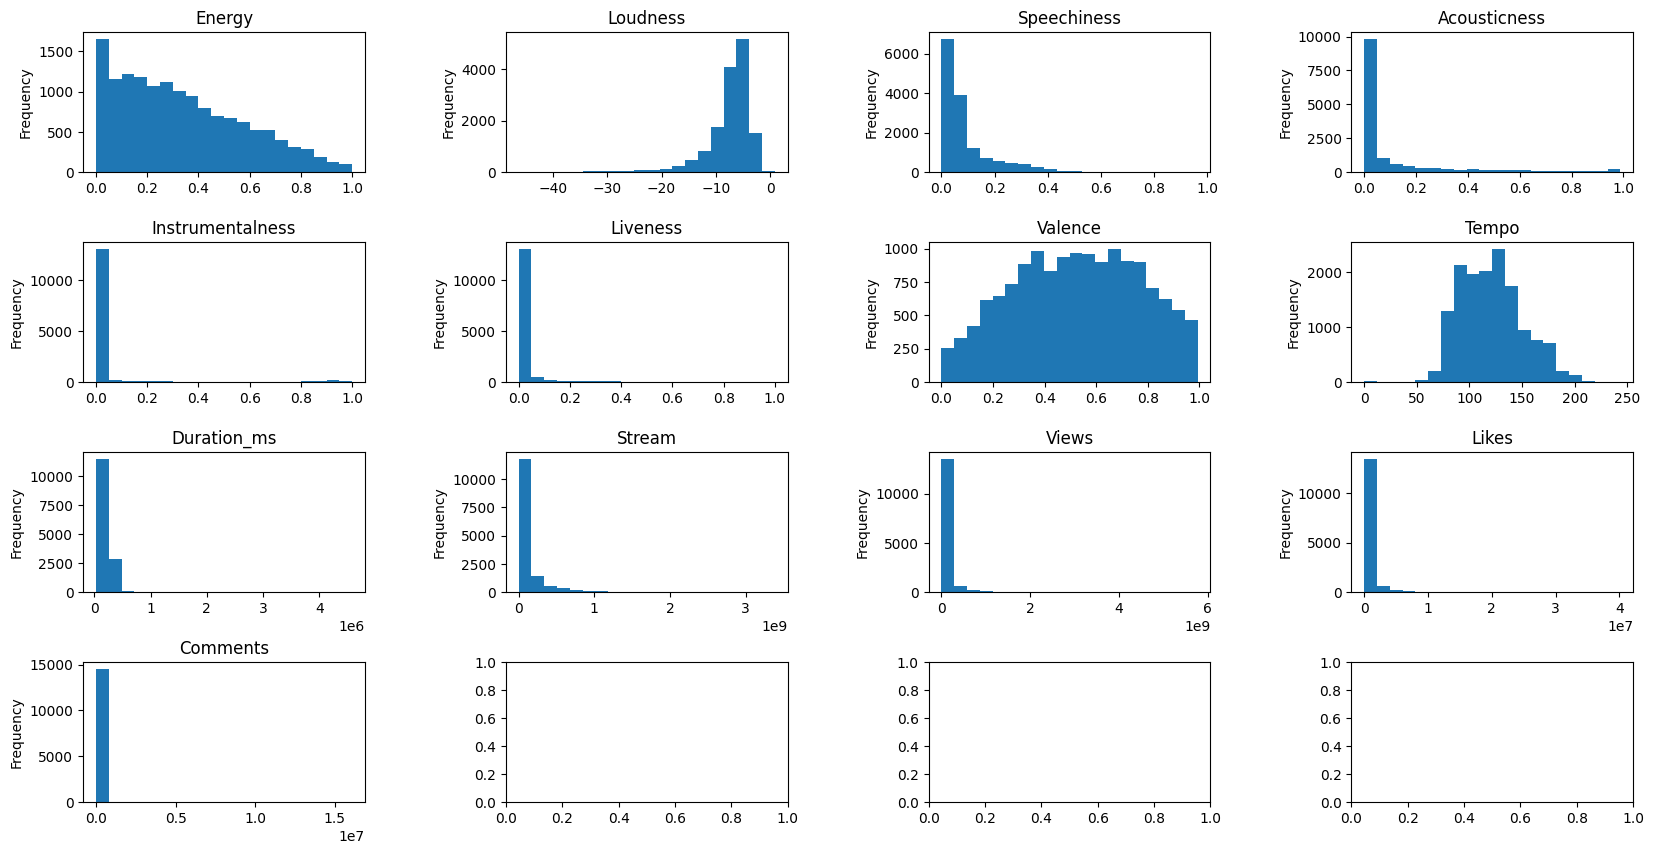

In [162]:
# plot distribution of numerical features
def plot_distribution(df, features):
    fig, axes = plt.subplots(4, 4, figsize=(20, 10))
    axes = axes.flatten()
    # Adjust spacing between subplots
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    for i, feature in enumerate(features):
        df[feature].plot.hist(ax=axes[i], bins=20)
        axes[i].set_title(feature)
    plt.show()
    
plot_distribution(train_ds, numerical_features)

In [163]:
skewed_features = ['Energy', 'Loudness', 'Duration_ms', 'Stream', 'Views', 'Likes', 'Comments']
special_skewed_features = ['Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness']

normal_features = ['Valence', 'Tempo']

# Normalize numerical feastures

In [164]:
# Initialize the StandardScaler object
normal_transformer = StandardScaler()
skewed_transformer = PowerTransformer()
special_transformer = PowerTransformer()

# Fit the scaler on your training dataset
normal_transformer.fit(train_ds[normal_features])
skewed_transformer.fit(train_ds[skewed_features])
special_transformer.fit(train_ds[special_skewed_features])

# Normalize the numerical features in the training dataset
trainsformed_train_ds = train_ds.copy()
trainsformed_train_ds[normal_features] = normal_transformer.transform(train_ds[normal_features])
trainsformed_train_ds[skewed_features] = skewed_transformer.transform(train_ds[skewed_features])
trainsformed_train_ds[special_skewed_features] = special_transformer.transform(train_ds[special_skewed_features])

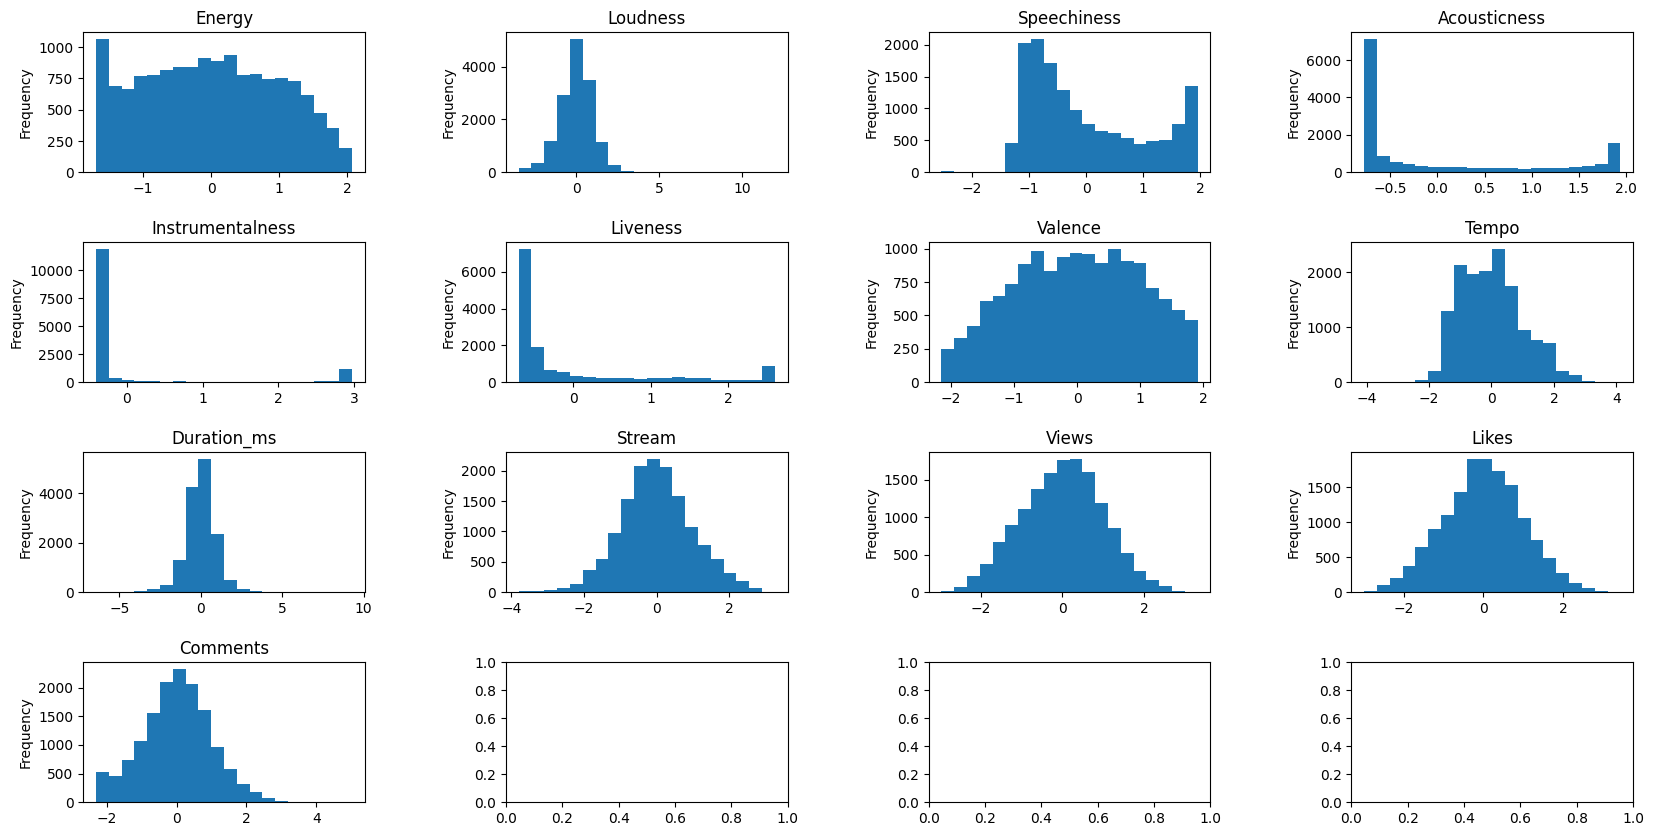

In [165]:
plot_distribution(trainsformed_train_ds, numerical_features)

# One-hot encode categorical features

In [173]:
# One-hot encode categorical features
trainsformed_train_ds = trainsformed_train_ds[numerical_features + categorical_features + [label_feature]]
trainsformed_dummy_train_ds = pd.get_dummies(trainsformed_train_ds, columns=categorical_features)

# Transform Label

In [178]:
label_transformer = StandardScaler()
label_transformer.fit(trainsformed_dummy_train_ds[[label_feature]])
trainsformed_dummy_train_ds[[label_feature]] = label_transformer.transform(trainsformed_dummy_train_ds[[label_feature]])

# Train regression

In [199]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Create an instance of the XGBRegressor
xgb_regressor = XGBRegressor()

# Fit the XGBRegressor on the training data
xgb_regressor.fit(X_train, Y_train)

# Make predictions on the training set
train_predictions = xgb_regressor.predict(X_train)
train_predictions = label_transformer.inverse_transform([train_predictions])
Y_train = label_transformer.inverse_transform([Y_train])

# Calculate MAE for the training set
train_mae = mean_absolute_error(Y_train, train_predictions)

# Make predictions on the validation set
val_predictions = xgb_regressor.predict(X_val)
val_predictions = label_transformer.inverse_transform([val_predictions])
Y_val = label_transformer.inverse_transform([Y_val])

# Calculate MAE for the validation set
val_mae = mean_absolute_error(Y_val, val_predictions)

print("Training MAE:", train_mae)
print("Validation MAE:", val_mae)


Training MAE: 1.7009561315805815
Validation MAE: 1.8267015956742023


# Predict Test Data

In [193]:
test_ds = pd.read_csv('data/test.csv')

# transform test data
